<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula11a_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-06-16 23:27:15--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.57.168, 54.231.166.72, 3.5.16.31, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.57.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.6MB/s    in 0.6s    

2025-06-16 23:27:16 (21.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')
with open(fname) as f:
  data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [13]:
raw_data.shape

(420451, 14)

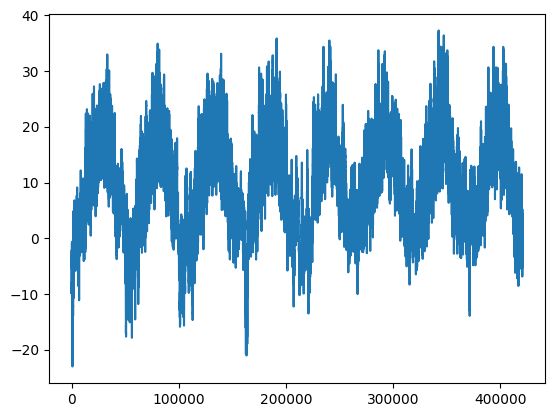

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

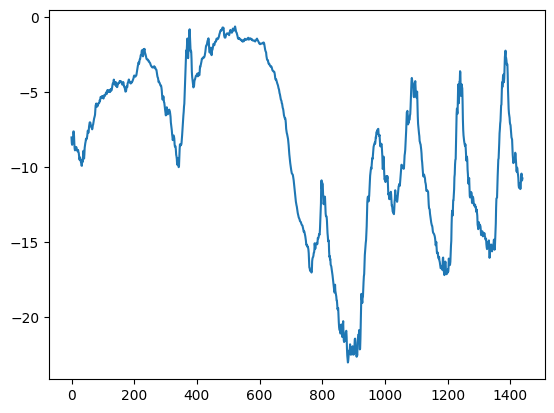

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
#

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
    shuffle=True
)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[1, 2, 3] 4
[2, 3, 4] 5
[4, 5, 6] 7
[0, 1, 2] 3
[3, 4, 5] 6


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 + 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    end_index=num_train_samples
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_val_samples + num_train_samples
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_val_samples + num_train_samples
)
#

In [10]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


#baseline

In [11]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print("Validation MAE (naive method):", evaluate_naive_method(val_dataset))
print("Test MAE (naive method):", evaluate_naive_method(test_dataset))

Validation MAE (naive method): 2.755512174562732
Test MAE (naive method): 2.9536019511252785


#densely connected

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Use Reshape instead of Flatten
x = layers.Reshape((-1, sequence_length * raw_data.shape[-1]))(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 81.6713 - mae: 7.3058 - val_loss: 68.8441 - val_mae: 6.8174
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - loss: 77.2788 - mae: 7.1187 - val_loss: 65.1324 - val_mae: 6.6339
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - loss: 76.9690 - mae: 7.1066 - val_loss: 66.3914 - val_mae: 6.7044
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 76.7878 - mae: 7.0970 - val_loss: 65.4615 - val_mae: 6.6576
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 76.7592 - mae: 7.0962 - val_loss: 65.2852 - val_mae: 6.6401
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 76.6866 - mae: 7.0931 - val_loss: 65.8116 - val_mae: 6.6769
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 76.6886 - mae: 7.0946 - val_loss: 67.1135 - val_mae: 6.7394
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 76.6668 - mae: 7.0939 - val_loss: 66.1599 - val_mae: 6.6943
Epoch 9/10
819/819 ━━━━━

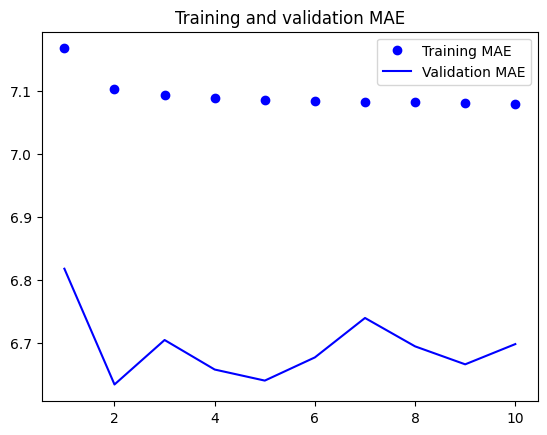

In [22]:
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure
plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.show()

#1D convolutional model

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - loss: 27.0891 - mae: 4.0671 - val_loss: 15.0167 - val_mae: 3.0758
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 16.2333 - mae: 3.1964 - val_loss: 16.5705 - val_mae: 3.2018
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 14.6509 - mae: 3.0230 - val_loss: 15.2427 - val_mae: 3.0859
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 13.7665 - mae: 2.9284 - val_loss: 15.2974 - val_mae: 3.0880
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 13.0755 - mae: 2.8490 - val_loss: 17.9851 - val_mae: 3.3408
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 12.5740 - mae: 2.7920 - val_loss: 16.1597 - val_mae: 3.1595
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 77s 46ms/step - loss: 12.0947 - mae: 2.7398 - val_loss: 17.5278 - val_mae: 3.2886
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 11.6714 - mae: 2.6924 - val_loss: 15.9772 - val_mae: 3.1513
Epoch 9/10
819/819 ━━━━━

#Rede Recorrente


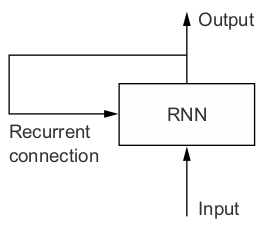

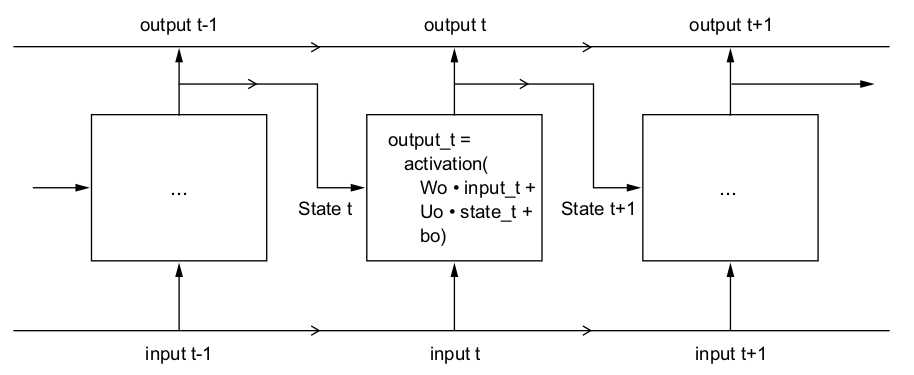

# LSTM

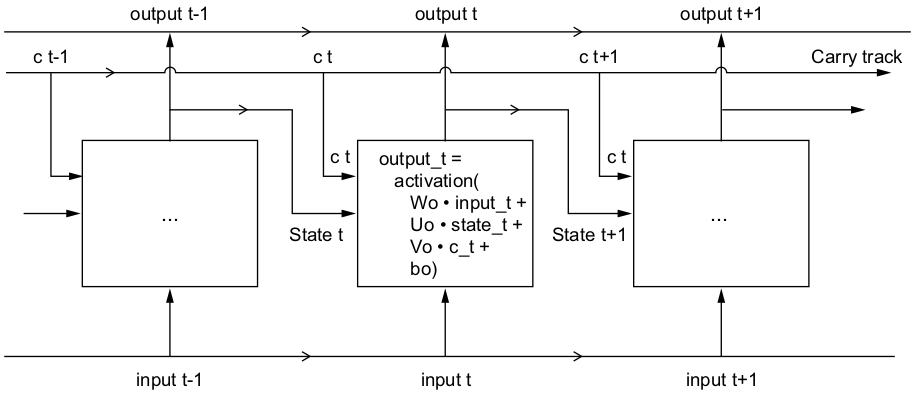

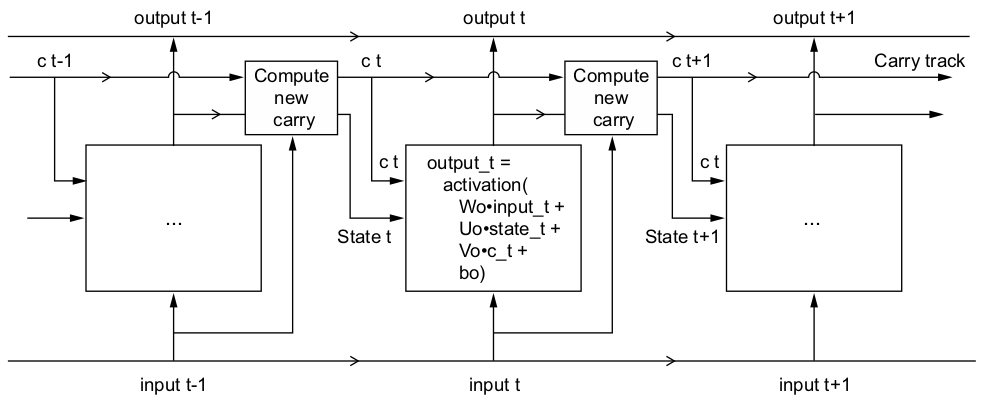

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - loss: 72.7420 - mae: 6.5482 - val_loss: 14.6844 - val_mae: 2.9491
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 14.3824 - mae: 2.9605 - val_loss: 11.4179 - val_mae: 2.6243
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 11.7219 - mae: 2.6941 - val_loss: 11.5074 - val_mae: 2.6289
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 51ms/step - loss: 10.9271 - mae: 2.5984 - val_loss: 12.0010 - val_mae: 2.6638
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 10.2946 - mae: 2.5216 - val_loss: 11.4918 - val_mae: 2.6119
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 9.9410 - mae: 2.4779 - val_loss: 11.3814 - val_mae: 2.6088
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 9.7294 - mae: 2.4490 - val_loss: 11.6877 - val_mae: 2.6470
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step - loss: 9.5400 - mae: 2.4243 - val_loss: 11.5646 - val_mae: 2.6109
Epoch 9/10
819/819 ━━━━━━━━

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1)(x)
model = keras.Model(inputs, output)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

#bidirectional LSTM

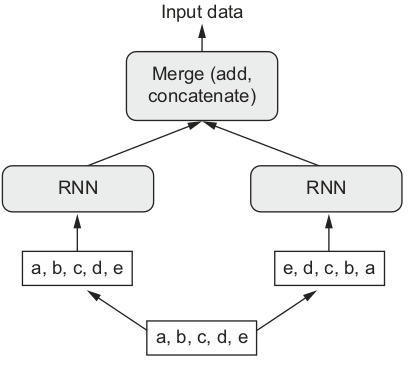

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_bidirecional.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_lstm_bidirecional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 62ms/step - loss: 54.9100 - mae: 5.5170 - val_loss: 12.3983 - val_mae: 2.7514
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 11.0120 - mae: 2.6042 - val_loss: 11.3668 - val_mae: 2.6370
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 9.4367 - mae: 2.4004 - val_loss: 11.0765 - val_mae: 2.5832
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - loss: 8.7515 - mae: 2.3119 - val_loss: 11.1741 - val_mae: 2.6031
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - loss: 8.3369 - mae: 2.2572 - val_loss: 11.4625 - val_mae: 2.6478
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 61ms/step - loss: 8.0005 - mae: 2.2109 - val_loss: 12.0728 - val_mae: 2.6961
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 7.6655 - mae: 2.1653 - val_loss: 12.1054 - val_mae: 2.7112
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 7.3846 - mae: 2.1216 - val_loss: 12.7056 - val_mae: 2.7781
Epoch 9/10
819/819 ━━━━━━━━━━━